In [ ]:
from typing import Literal
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

def hotel_agent(state: MessagesState):
    messages = AIMessage(content="해당 에이전트는 호텔 업무와 관련된 작업을 처리합니다.")

    return Command(
        goto = "flight_agent",
        update = {"messages": [messages]},
    )

def flight_agent(state: MessagesState):
    messages = AIMessage(content="해당 에이전트는 항공 업무와 관련된 작업을 처리합니다.")

    return Command(
        goto = END,
        update = {"messages": [messages]},
    )

graph_builder = StateGraph(MessagesState)
graph_builder.add_node("hotel_agent", hotel_agent)
graph_builder.add_node("flight_agent", flight_agent)

graph_builder.add_edge(START, "hotel_agent")

graph = graph_builder.compile()


for chunk in graph.stream({"messages" : []}, stream_mode = "values"):
    print(chunk)

{'messages': []}
{'messages': [AIMessage(content='해당 에이전트는 호텔 업무와 관련된 작업을 처리합니다.', additional_kwargs={}, response_metadata={}, id='3754d385-0adc-4cf7-9d2d-58f419783193')]}
{'messages': [AIMessage(content='해당 에이전트는 호텔 업무와 관련된 작업을 처리합니다.', additional_kwargs={}, response_metadata={}, id='3754d385-0adc-4cf7-9d2d-58f419783193'), AIMessage(content='해당 에이전트는 항공 업무와 관련된 작업을 처리합니다.', additional_kwargs={}, response_metadata={}, id='222eae3a-15a0-436f-875b-6dcbb3621017')]}


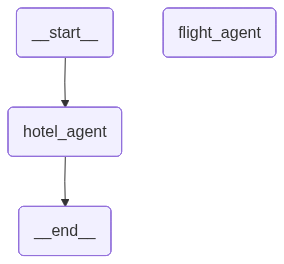

In [2]:
from IPython.display import display, Image
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [3]:
from langchain_openai import ChatOpenAI

# 1. LLM 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# 2. 도구 정의
@tool
def transfer_to_book():
    """예약을 하기 위한 에이전트를 호출하는 도구"""
    return Command(
        goto="book",
        update={"my_state_key": "my_state_value"},
        graph=Command.PARENT
    )

# 3. 도구를 LLM에 바인딩
tools = [transfer_to_book]
llm_with_tools = llm.bind_tools(tools)

# 4. 에이전트 노드에서 사용
def hotel_agent(state: MessagesState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


In [4]:
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model

def setup_llm(model: str = "gpt-4.1-mini", temperature: float = 0, logprobs: bool = False):
    """
    Initialize LLM for the agent.
    
    Args:
        model: 모델 ID
        temperature: 샘플링 온도
        logprobs: True면 logprobs 반환 (perplexity 계산용)
    """
    llm = init_chat_model(
        model=model, model_provider="openai", temperature=temperature
    )
    if logprobs:
        llm = llm.bind(logprobs=True)
    return llm


# 도구 리스트
tools = [transfer_to_book]

# ReAct 에이전트 생성 (도구 자동 바인딩)
hotel_agent = create_agent(llm, tools)

In [2]:
"""
Personal Assistant Supervisor Example

This example demonstrates the tool calling pattern for multi-agent systems.
A supervisor agent coordinates specialized sub-agents (calendar and email)
that are wrapped as tools.
"""

from langchain.tools import tool
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model

# ============================================================================
# Step 1: Define low-level API tools (stubbed)
# ============================================================================

@tool
def create_calendar_event(
    title: str,
    start_time: str,  # ISO format: "2024-01-15T14:00:00"
    end_time: str,    # ISO format: "2024-01-15T15:00:00"
    attendees: list[str],  # email addresses
    location: str = ""
) -> str:
    """Create a calendar event. Requires exact ISO datetime format."""
    return f"Event created: {title} from {start_time} to {end_time} with {len(attendees)} attendees"


@tool
def send_email(
    to: list[str],      # email addresses
    subject: str,
    body: str,
    cc: list[str] = []
) -> str:
    """Send an email via email API. Requires properly formatted addresses."""
    return f"Email sent to {', '.join(to)} - Subject: {subject}"


@tool
def get_available_time_slots(
    attendees: list[str],
    date: str,  # ISO format: "2024-01-15"
    duration_minutes: int
) -> list[str]:
    """Check calendar availability for given attendees on a specific date."""
    return ["09:00", "14:00", "16:00"]


# ============================================================================
# Step 2: Create specialized sub-agents
# ============================================================================


def setup_llm(model: str = "gpt-4.1-mini", temperature: float = 0, logprobs: bool = False):
    """
    Initialize LLM for the agent.
    
    Args:
        model: 모델 ID
        temperature: 샘플링 온도
        logprobs: True면 logprobs 반환 (perplexity 계산용)
    """
    llm = init_chat_model(
        model=model, model_provider="openai", temperature=temperature
    )
    if logprobs:
        llm = llm.bind(logprobs=True)
    return llm

model = setup_llm()

calendar_agent = create_agent(
    model,
    tools=[create_calendar_event, get_available_time_slots],
    system_prompt=(
        "You are a calendar scheduling assistant. "
        "Parse natural language scheduling requests (e.g., 'next Tuesday at 2pm') "
        "into proper ISO datetime formats. "
        "Use get_available_time_slots to check availability when needed. "
        "Use create_calendar_event to schedule events. "
        "Always confirm what was scheduled in your final response."
    )
)

email_agent = create_agent(
    model,
    tools=[send_email],
    system_prompt=(
        "You are an email assistant. "
        "Compose professional emails based on natural language requests. "
        "Extract recipient information and craft appropriate subject lines and body text. "
        "Use send_email to send the message. "
        "Always confirm what was sent in your final response."
    )
)

# ============================================================================
# Step 3: Wrap sub-agents as tools for the supervisor
# ============================================================================

@tool
def schedule_event(request: str) -> str:
    """Schedule calendar events using natural language.

    Use this when the user wants to create, modify, or check calendar appointments.
    Handles date/time parsing, availability checking, and event creation.

    Input: Natural language scheduling request (e.g., 'meeting with design team
    next Tuesday at 2pm')
    """
    result = calendar_agent.invoke({
        "messages": [{"role": "user", "content": request}]
    })
    return result["messages"][-1].text


@tool
def manage_email(request: str) -> str:
    """Send emails using natural language.

    Use this when the user wants to send notifications, reminders, or any email
    communication. Handles recipient extraction, subject generation, and email
    composition.

    Input: Natural language email request (e.g., 'send them a reminder about
    the meeting')
    """
    result = email_agent.invoke({
        "messages": [{"role": "user", "content": request}]
    })
    return result["messages"][-1].text


# ============================================================================
# Step 4: Create the supervisor agent
# ============================================================================

supervisor_agent = create_agent(
    model,
    tools=[schedule_event, manage_email],
    system_prompt=(
        "You are a helpful personal assistant. "
        "You can schedule calendar events and send emails. "
        "Break down user requests into appropriate tool calls and coordinate the results. "
        "When a request involves multiple actions, use multiple tools in sequence."
    )
)

# ============================================================================
# Step 5: Use the supervisor
# ============================================================================

# Example: User request requiring both calendar and email coordination
user_request = (
    "Schedule a meeting with the design team next Tuesday at 2pm for 1 hour, "
    "and send them an email reminder about reviewing the new mockups."
)

print("User Request:", user_request)
print("\n" + "="*80 + "\n")

for step in supervisor_agent.stream(
    {"messages": [{"role": "user", "content": user_request}]}
):
    for update in step.values():
        for message in update.get("messages", []):
            message.pretty_print()

User Request: Schedule a meeting with the design team next Tuesday at 2pm for 1 hour, and send them an email reminder about reviewing the new mockups.


================================== Ai Message ==================================
Tool Calls:
  schedule_event (call_5Bat750TReYmbvGRZuQonChK)
 Call ID: call_5Bat750TReYmbvGRZuQonChK
  Args:
    request: meeting with the design team next Tuesday at 2pm for 1 hour
  manage_email (call_waahDIrhvifgZRllMp3q0KLK)
 Call ID: call_waahDIrhvifgZRllMp3q0KLK
  Args:
    request: send an email reminder to the design team about reviewing the new mockups
================================= Tool Message =================================
Name: manage_email

I have sent a reminder email to the design team about reviewing the new mockups. If you need any further assistance, please let me know.
================================= Tool Message =================================
Name: schedule_event

I have scheduled the meeting with the design team next Tuesda

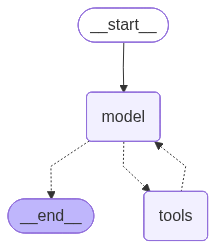

In [3]:
from IPython.display import display, Image
display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png()))

╭──────────── Handoff with Separate States ────────────╮
│ HotelState: hotel_name, price                        │
│ BookingState: hotel_name, price, check_in, check_out │
│                                                      │
│ HotelAgent(select → transfer)                        │
│     ↓ Command: hotel_name, price 전달                │
│ BookingAgent(set_dates → confirm)                    │
╰──────────────────────────────────────────────────────╯

Initial: {'hotel_name': '', 'price': 0, 'check_in': '', 'check_out': ''}

==================================================

🏨 [HotelAgent] select

→ hotel_name: 그랜드 호텔

→ price: 150,000원

🤖 transfer_to_booking 호출

╭─ 🔄 transfer_to_booking ─╮
│ hotel_name: 그랜드 호텔  │
│ price: 150,000원         │
╰──────────────────────────╯

📅 [BookingAgent] set_dates

← 받은 hotel_name: 그랜드 호텔

← 받은 price: 150,000원

→ check_in: 2024-01-15

→ check_out: 2024-01-17

╭───── ✅ 예약 확정 ──────╮
│ hotel_name: 그랜드 호텔 │
│ price: 150,000원        │
│ check_in: 2024-01-15    │
│ check_out: 2024-01-17   │
╰─────────────────────────╯

==================================================

📊 xray=False (기본): subgraph 내부 안 보임
----------------------------------------


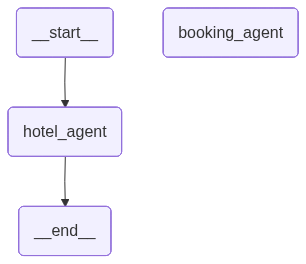


📊 xray=True: subgraph 내부 구조 보임!
----------------------------------------
Hotel Agent: search → filter → select (with transfer_to_book tool)
Booking Agent: confirm → payment → send_confirm


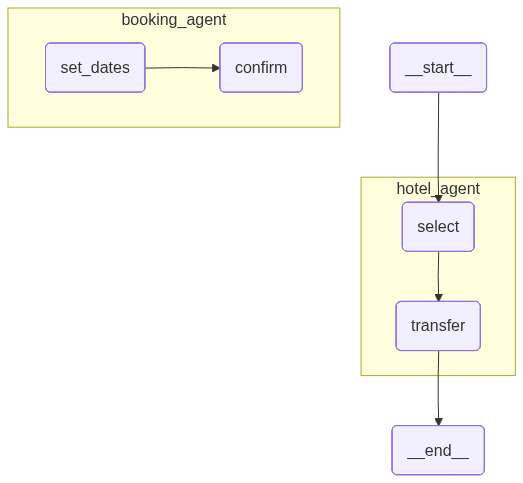

In [ ]:
"""
Handoff 패턴 - 분리된 State
- HotelState: hotel_name, price
- BookingState: hotel_name, price, check_in, check_out
"""
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_core.tools import tool
from rich import print as rprint
from rich.panel import Panel

# ============================================================================
# State 정의 - 각 Agent별 분리
# ============================================================================

class HotelState(TypedDict):
    hotel_name: str
    price: int

class BookingState(TypedDict):
    hotel_name: str  # HotelAgent에서 전달받음
    price: int       # HotelAgent에서 전달받음
    check_in: str    # BookingAgent가 설정
    check_out: str   # BookingAgent가 설정

# Parent Graph용 통합 State
class MainState(TypedDict):
    hotel_name: str
    price: int
    check_in: str
    check_out: str

# ============================================================================
# Transfer Tool - HotelState → BookingState로 핸드오프
# ============================================================================

@tool
def transfer_to_booking(hotel_name: str, price: int) -> Command:
    """BookingAgent로 핸드오프. hotel_name, price를 전달."""
    rprint(Panel.fit(
        f"hotel_name: {hotel_name}\nprice: {price:,}원",
        title="[red]🔄 transfer_to_booking[/red]",
        border_style="red"
    ))
    
    return Command(
        goto="booking_agent",
        update={
            "hotel_name": hotel_name,
            "price": price,
        },
        graph=Command.PARENT
    )

# ============================================================================
# Hotel Agent (HotelState 사용)
# ============================================================================

def select_hotel(state: HotelState):
    """호텔 선택 - hotel_name, price 결정"""
    rprint("[yellow]🏨 [HotelAgent] select[/yellow]")
    
    hotel_name = "그랜드 호텔"
    price = 150000
    
    rprint(f"   → hotel_name: {hotel_name}")
    rprint(f"   → price: {price:,}원")
    
    return {"hotel_name": hotel_name, "price": price}

def call_transfer(state: HotelState):
    """transfer 도구 호출"""
    rprint("\n[cyan]🤖 transfer_to_booking 호출[/cyan]\n")
    
    return transfer_to_booking.invoke({
        "hotel_name": state["hotel_name"],
        "price": state["price"],
    })

hotel_builder = StateGraph(HotelState)
hotel_builder.add_node("select", select_hotel)
hotel_builder.add_node("transfer", call_transfer)
hotel_builder.add_edge(START, "select")
hotel_builder.add_edge("select", "transfer")
hotel_subgraph = hotel_builder.compile()

# ============================================================================
# Booking Agent (BookingState 사용)
# ============================================================================

def set_dates(state: BookingState):
    """날짜 설정 - 전달받은 hotel_name, price 확인 후 날짜 추가"""
    rprint("[green]📅 [BookingAgent] set_dates[/green]")
    rprint(f"   ← 받은 hotel_name: {state.get('hotel_name')}")
    rprint(f"   ← 받은 price: {state.get('price', 0):,}원")
    
    check_in = "2024-01-15"
    check_out = "2024-01-17"
    
    rprint(f"   → check_in: {check_in}")
    rprint(f"   → check_out: {check_out}")
    
    return {"check_in": check_in, "check_out": check_out}

def confirm(state: BookingState):
    """예약 확정"""
    rprint(Panel.fit(
        f"hotel_name: {state['hotel_name']}\n"
        f"price: {state['price']:,}원\n"
        f"check_in: {state['check_in']}\n"
        f"check_out: {state['check_out']}",
        title="[green]✅ 예약 확정[/green]",
        border_style="green"
    ))
    return {}

booking_builder = StateGraph(BookingState)
booking_builder.add_node("set_dates", set_dates)
booking_builder.add_node("confirm", confirm)
booking_builder.add_edge(START, "set_dates")
booking_builder.add_edge("set_dates", "confirm")
booking_builder.add_edge("confirm", END)
booking_subgraph = booking_builder.compile()

# ============================================================================
# Main Graph (MainState로 통합)
# ============================================================================

main_builder = StateGraph(MainState)
main_builder.add_node("hotel_agent", hotel_subgraph)
main_builder.add_node("booking_agent", booking_subgraph)
main_builder.add_edge(START, "hotel_agent")
# ????
main_builder.add_edge("booking_agent", END)

main_graph = main_builder.compile()

# ============================================================================
# 실행
# ============================================================================

rprint(Panel.fit(
    "[yellow]HotelState[/yellow]: hotel_name, price\n"
    "[green]BookingState[/green]: hotel_name, price, check_in, check_out\n\n"
    "HotelAgent(select → transfer)\n"
    "    ↓ Command: hotel_name, price 전달\n"
    "BookingAgent(set_dates → confirm)",
    title="[blue]Handoff with Separate States[/blue]",
    border_style="blue"
))

initial_state: MainState = {
    "hotel_name": "",
    "price": 0,
    "check_in": "",
    "check_out": "",
}

rprint(f"\n[bold]Initial:[/bold] {initial_state}\n")
rprint("=" * 50)

for chunk in main_graph.stream(initial_state, stream_mode="values"):
    pass

rprint("=" * 50)


# xray=True로 subgraph 내부 구조까지 시각화
from IPython.display import display, Image

print("📊 xray=False (기본): subgraph 내부 안 보임")
print("-" * 40)
display(Image(main_graph.get_graph(xray=False).draw_mermaid_png()))

print("\n📊 xray=True: subgraph 내부 구조 보임!")
print("-" * 40)
print("Hotel Agent: search → filter → select (with transfer_to_book tool)")
print("Booking Agent: confirm → payment → send_confirm")
display(Image(main_graph.get_graph(xray=True).draw_mermaid_png()))

```
  Multi-Agent 핵심 개념:

  | 개념       | 설명                              |
  |----------|---------------------------------|
  | Agent    | 독립적인 StateGraph (자체 State, 노드들) |
  | Subgraph | 컴파일된 Agent를 부모 그래프의 노드로 사용      |
  | Handoff  | Agent 간 제어권 + 데이터 전달            |
  | Command  | goto + update로 동적 라우팅           |

  이번 예제에서 배운 것:

  HotelAgent (HotelState)          BookingAgent (BookingState)
  ┌──────────────────┐             ┌──────────────────┐
  │  select          │             │  set_dates       │
  │  (hotel_name,    │   Command   │  (check_in,      │
  │   price 설정)    │ ──────────→ │   check_out 설정)│
  │       ↓          │  goto +     │       ↓          │
  │  transfer (도구) │  update     │  confirm         │
  └──────────────────┘             └──────────────────┘

  핵심 패턴:
  1. 각 Agent는 자기 역할만 수행 (호텔 선택 / 예약 처리)
  2. Handoff Tool이 Command 반환 → 다음 Agent로 이동 + 데이터 전달
  3. xray=True로 내부 구조 시각화 (단, Command 동적 라우팅은 안 보임)
```